In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import LabelEncoder

# Read in data

In [2]:
def cleanse_data(df):
    '''Useful for modeling and plotting data'''
    df['Date'] = pd.to_datetime(df.Date)
    df['Yr'] = df.Date.dt.year 
    df['Day'] = df.Date.dt.dayofyear
    df['Month'] = df.Date.dt.month

    return df

In [3]:
traindf = pd.read_csv('../input/train.csv')
traindf = cleanse_data(traindf)

testdf = pd.read_csv('../input/test.csv')
testdf = cleanse_data(testdf)
testdf = testdf.set_index('Id')

df_all = pd.concat([traindf,testdf])

# just use 2007 for first pass
traindf07 = traindf[(traindf.Date>'2007-01-01') & (traindf.Date<'2007-10-10')]

In [5]:
plt.rcParams['figure.figsize'] = (14,6)
plt.style.use('fivethirtyeight')

# Exploration

## Westnile vs. time
Aggregate by week or day? First want to aggregate by day, then we can smooth or whatever

In [ ]:
for i,(yr,_df) in enumerate(traindf.groupby('Yr')):
    plt.subplot(2,2,i+1)
    wnv_sum = _df.groupby('Date')['WnvPresent'].sum()
    wnv_sum.plot()
    plt.title(yr)
    plt.tight_layout()
    plt.ylabel("# WNV instances", size = 8)
plt.suptitle('Number of West Nile instances, per 50 mosquitos vs. Time')

## Total number of mosquitos

In [ ]:
for i,(yr,_df) in enumerate(traindf.groupby('Yr')):
    plt.subplot(2,2,i+1)
    wnv_sum = _df.groupby('Date')['NumMosquitos'].sum()
    wnv_sum.plot()
    plt.title(yr)
    plt.tight_layout()
plt.suptitle('Num Mosquitos vs. Time')

# Mosquito frequency
Want to see in training data, how much we see of each type of mosquito, can plot behaviour over time

In [ ]:
plt.rcParams['axes.color_cycle']

In [ ]:
df = traindf.groupby('Species').aggregate({'NumMosquitos':'sum'})
vc = pd.Series(df.NumMosquitos).sort_values(ascending=False)
def plot_mosquito_freq(vc,**plotargs):
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    loc = np.arange(len(vc))
    height = .8
    ax.barh(loc,vc[::-1], height = height,**plotargs)
    ax.set_yticks(loc + height/2)
    ax.set_yticklabels(vc.index[::-1])
    return ax
ax = plot_mosquito_freq(vc,**{'color':'#30a2da'})
plt.xlabel('# mosquitos')
plt.title('Mosquito species frequency in training data')
plt.tight_layout()
plt.savefig('../results/{}.png'.format(ax.get_title()))

In [ ]:
query_str = "WnvPresent == 1"
df = traindf.\
     query(query_str).\
     groupby('Species').\
     aggregate({'NumMosquitos':'sum'})
vc = pd.Series(df.NumMosquitos).sort_values(ascending=False)
ax = plot_mosquito_freq(vc,**{'color':'#fc4f30'})
plt.title('WNV per 50 mosquitos by species in training data')
plt.xlabel('observations')
plt.tight_layout()
plt.savefig('../results/{}.png'.format(ax.get_title()))

# Model2 - Now using mosquito type

In [10]:
def to_dummy(df, dummy_cl = None):
    if not dummy_cl:
        dummy_cl = DV()
    input_df = df.T.to_dict().values()
    dummy_cl.fit(input_df)
    res = dummy_cl.transform(input_df)
    df2 = pd.DataFrame(res.toarray().T,dummy_cl.feature_names_).T
    return df2, dummy_cl

def year_experiment(df,test_yr,features):
    '''For k-fold cross validation,
    we want experiment to have a test fold of a given year
    and the training folds to be all over years.'''
    
    def get_fold_ix(df, test_yr):
        test_fold = df.query('Yr == {test_yr}'.format(test_yr = test_yr))
        train_folds = df.query('Yr != {test_yr}'.format(test_yr = test_yr))
        return train_folds.index,test_fold.index
    
    train_ix,test_ix = get_fold_ix(df,test_yr)
    X = df[features]
    X,dummy_cl = to_dummy(X)
    y = df['WnvPresent']

    Xtrain,Xtest,ytrain,ytest = [X.iloc[train_ix],
                                 X.iloc[test_ix],
                                 y.iloc[train_ix],
                                 y.iloc[test_ix]]
    return (Xtrain,Xtest,ytrain,ytest), dummy_cl



In [ ]:
_ = traindf.groupby(['Day','Trap','Species'])
df = _.aggregate({'WnvPresent':'max',
                  'Longitude':'max',
                  'Latitude':'max',
                  'Yr':'max',
                  'Date':'max'}) # can use max of lon/lat bc same for all stations
traindf_agg = df.reset_index()

yr = 2009
features = ['Day','Species','Trap']
(Xtrain,Xtest,ytrain,ytest), dummy_cl = year_experiment(traindf_agg,yr,features)

In [ ]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
cl = RandomForestClassifier(n_estimators=1000,n_jobs = -1, class_weight = 'balanced')
cl.fit(Xtrain,ytrain)

In [ ]:
aucs = []
for yr in [2007,2009,2011,2013]:
    (Xtrain,Xtest,ytrain,ytest), dummy_cl = year_experiment(traindf_agg,yr,features)
    cl = RandomForestClassifier(n_estimators=1000,n_jobs = -1)
    cl.fit(Xtrain,ytrain)
    yprob = cl.predict_proba(Xtest)[:,1]
    aucs.append((roc_auc_score(ytest, yprob)))
print(aucs)
print(np.mean(aucs))
# yprob = cl.predict_proba(Xtest)[:,1]
# plot_roc(ytest, yprob)

# Add weather data

In [6]:
def apply_rolling_window(weatherdf, WEATHER_FEATURES):
    
    def fill_first_null(s):
        return s[~s.isnull()].iloc[0]
    
    _dfs = []
    for yr,_df in weatherdf.groupby('Year'):
        _df = _df[WEATHER_FEATURES].rolling(NDAYS).mean()
        for f in WEATHER_FEATURES:
            first_value = fill_first_null(_df[f])
            _df[f] = _df[f].fillna(first_value)
        _dfs.append(_df)
    df = pd.concat(_dfs)
    return df

def remove_whitespace(df):
    for c in df.select_dtypes(include=['object']):
        df[c] = df[c].str.strip()
    return df

In [7]:
_ = traindf.groupby(['Day','Trap','Species'])
df = _.aggregate({'WnvPresent':'max',
                  'Longitude':'max',
                  'Latitude':'max',
                  'Yr':'max',
                  'Date':'max'}) # can use max of lon/lat bc same for all stations
traindf_agg = df.reset_index()

weatherdf = pd.read_csv('../input/weather.csv').drop(['Station','CodeSum'],axis = 1)
weatherdf['Date'] = pd.to_datetime(weatherdf['Date'])
weatherdf['Year'] = weatherdf.Date.dt.year
weatherdf['Day'] = weatherdf.Date.dt.dayofyear
weatherdf = weatherdf.set_index('Date')

weatherdf = remove_whitespace(weatherdf)
weatherdf = weatherdf.replace(r'^[^\d.]+$', 0, regex=True)
for c in weatherdf.columns:
    weatherdf[c] = pd.to_numeric(weatherdf[c])
weatherdf = weatherdf.reset_index()

weatherdf = weatherdf.groupby('Date',as_index = False).mean()

In [8]:
# weather
WEATHER_FEATURES = weatherdf.drop(['Date','Year','Day'], axis = 1).columns.tolist()

# NDAYS = 30
for n in [3,5,7]:
# for n in [3]:
    NDAYS = n
    FEATURES_ROLLING = ['{}_rolling{}'.format(f,NDAYS) for f in WEATHER_FEATURES]
    weatherdf[FEATURES_ROLLING] = apply_rolling_window(weatherdf, WEATHER_FEATURES) 
    
# merge weather with other other data
df_merge = traindf_agg.merge(weatherdf,on = 'Date',how='inner')

In [14]:
FEATURES = df_merge.drop(['Date','WnvPresent','Longitude','Latitude'], axis = 1).columns.tolist()
aucs = []
ytrues,yprobs = [],[]
train_yrs = [2007,2009,2011,2013]
for yr in train_yrs:
    (Xtrain,Xtest,ytrain,ytest), dummy_cl = year_experiment(df_merge,yr,FEATURES)
    cl = RandomForestClassifier(n_estimators=1000,n_jobs = -1)
#     cl = LogisticRegression()
    cl.fit(Xtrain,ytrain)
    yprob = cl.predict_proba(Xtest)[:,1]
    ytrues.append(ytest.values)
    yprobs.append(yprob)
    aucs.append((roc_auc_score(ytest, yprob)))
print(aucs)
print(np.mean(aucs))

[0.70787450831069665, 0.76299044325985688, 0.71906525624027207, 0.72292345787005075]
0.72821341642


AUC: 0.716970547938
AUC: 0.769293569611
AUC: 0.769520666398
AUC: 0.729971502573


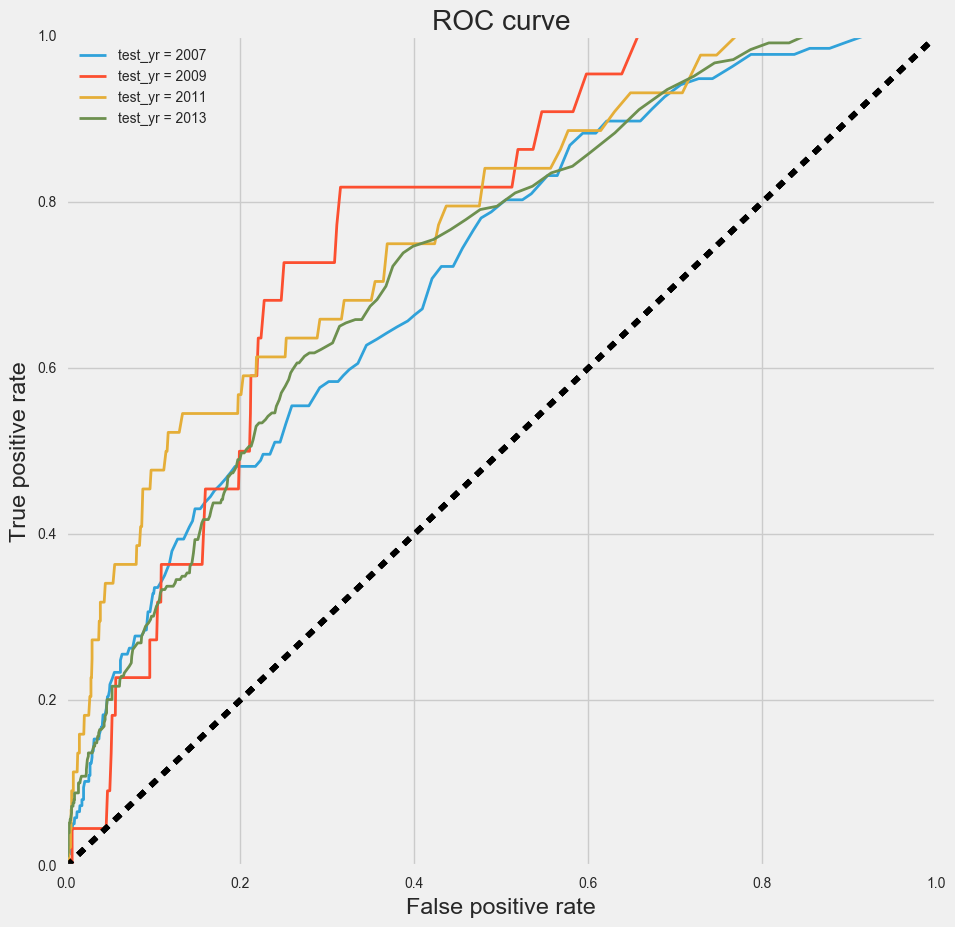

In [98]:
plt.figure(1,figsize=(10,10))
for (ytest,ypred_prob),yr in zip(zip(ytrues,yprobs),train_yrs):
    print "AUC: {}".format(roc_auc_score(ytest, ypred_prob))
    fpr, tpr, _ = roc_curve(ytest, ypred_prob)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, linewidth = 2,label = 'test_yr = {}'.format(yr))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
plt.savefig('../results/ROC.png')

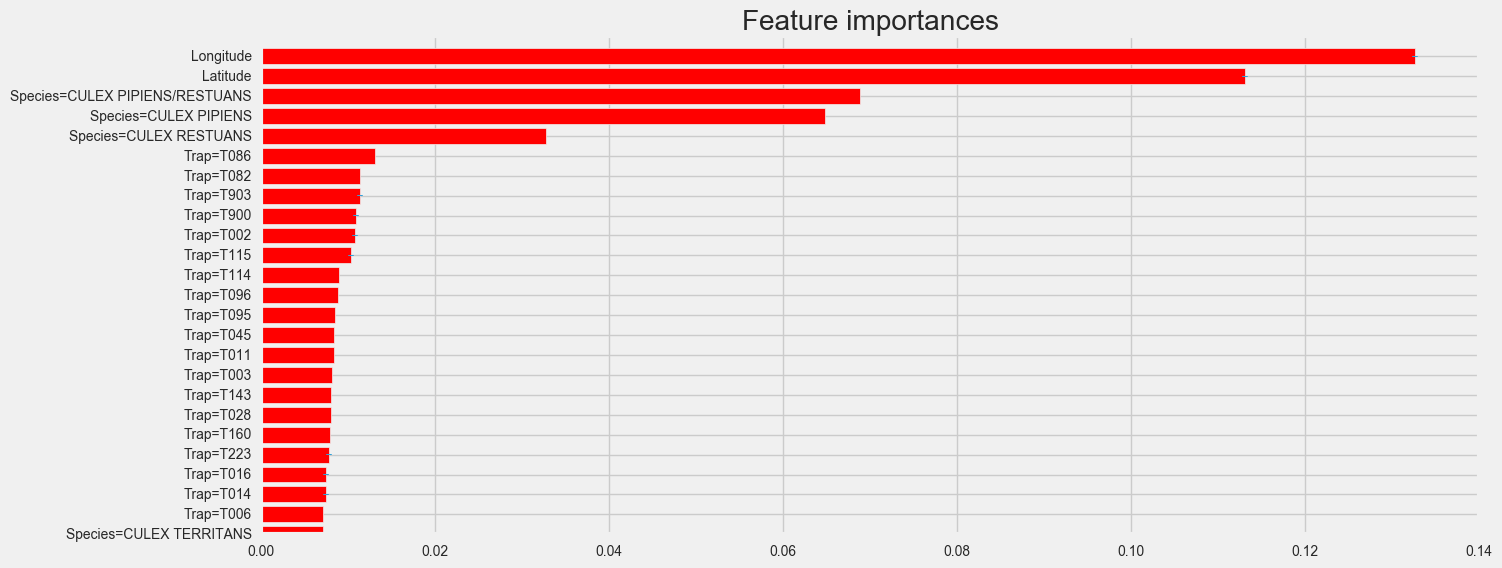

In [13]:
X = Xtrain
importances = cl.feature_importances_
std = np.std([tree.feature_importances_ for tree in cl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(Xtrain.shape[1])[::-1], importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(Xtrain.shape[1])[::-1], X.columns[indices])
plt.ylim([Xtrain.shape[1] - 25, Xtrain.shape[1]])
plt.show()

# Plot Weather

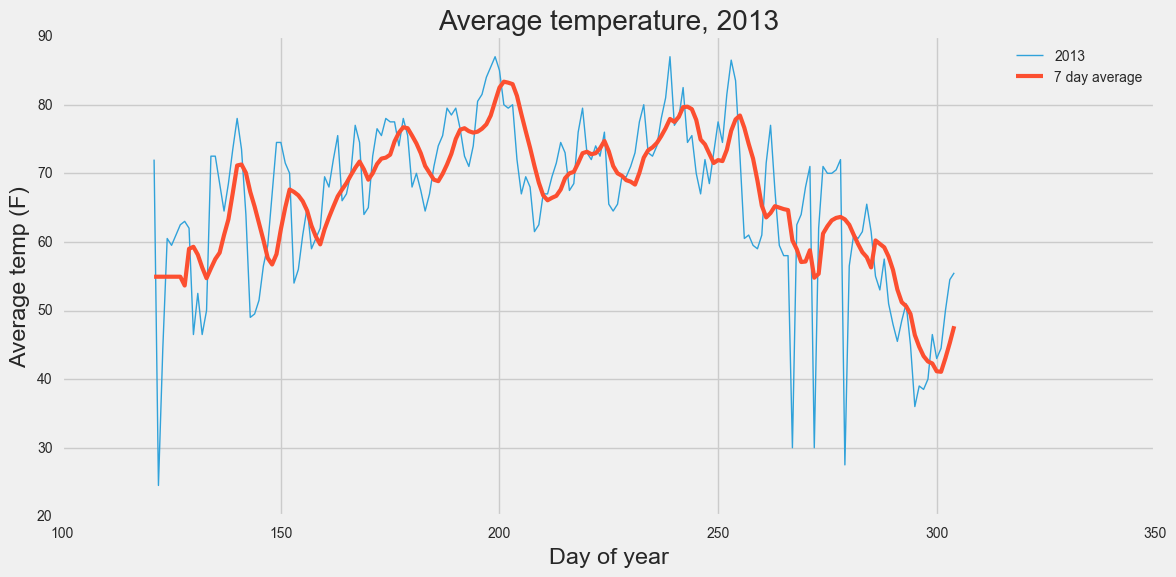

In [27]:
plt.figure(figsize = (12,6))
plt.plot(weather2.Date.dt.dayofyear,weather2.Tavg,linewidth = 1,label = 2013)
plt.plot(weather2.Date.dt.dayofyear,weather2.Tavg_rolling7,linewidth = 3,label = '7 day average')
plt.xlabel('Day of year')
plt.ylabel('Average temp (F)')
plt.legend()
plt.title('Average temperature, 2013')
plt.tight_layout()
plt.savefig('../results/2013_avg_temp.png')

In [ ]:
for yr in (2007,2009,2011,2013):
    weather2 = weatherdf[weatherdf.Date.dt.year == yr]
#     plt.plot(weather2.Date.dt.dayofyear,weather2.Tmax_rolling30,linewidth = 1,label = yr)
    plt.plot(weather2.Day,weather2.PrecipTotal.cumsum(),label = 1)
plt.legend()
# plt.plot(2009,50)

# data anomalies

In [ ]:
_ = traindf.groupby(['Trap','Longitude','Latitude'],as_index = False)
_.count().Trap.value_counts()

In [ ]:
np.unique(traindf.query('Trap == "T035"')[['Latitude','Longitude']])

# T009 -87.862995,41.981964
#       -87.812827,41.992478

# T035  -87.742302, 41.763733
#       -87.677737,   41.836644

In [ ]:
_ = traindf.groupby(['Trap','Longitude','Latitude'],as_index = False)
df = _.aggregate({'Day':'count'})

df = df.groupby(['Trap','Longitude','Latitude'], as_index = False).count()
df = df.groupby('Trap').sum()
df.sort_values('Day')
# df.reset_index()

# Apply to test data for submission
Train and test for testing

In [39]:
df = df_merge
FEATURES = df_merge.drop(['Date','Year','Yr','Day_x','Day_y','WnvPresent','Longitude','Latitude'], axis = 1).columns.tolist()
features = FEATURES

# test/train split 
X = df[features]

# dummy 
dummy_cl = DV()
input_df = X.T.to_dict().values()
dummy_cl.fit(input_df)
df_dummy = dummy_cl.transform(input_df)

# back to df
X = pd.DataFrame(df_dummy.toarray().T,dummy_cl.feature_names_).T

y = df.WnvPresent

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y)
cl = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
cl.fit(Xtrain, ytrain)

# build model
cl = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
cl.fit(X, y)
yprob = cl.predict_proba(X)[:,1]
roc_auc_score(y,yprob)

1.0

In [59]:
Xtrain

AvgSpeed  AvgSpeed_rolling3  AvgSpeed_rolling3_rolling3  \
0         8.20           7.750000                    8.533333   
1         8.20           7.750000                    8.533333   
2         8.20           7.750000                    8.533333   
3         8.20           7.750000                    8.533333   
4         8.20           7.750000                    8.533333   
5         8.20           7.750000                    8.533333   
6         8.20           7.750000                    8.533333   
7         8.20           7.750000                    8.533333   
8         8.20           7.750000                    8.533333   
9         8.20           7.750000                    8.533333   
10        8.20           7.750000                    8.533333   
11        8.20           7.750000                    8.533333   
12        8.20           7.750000                    8.533333   
13        8.20           7.750000                    8.533333   
14        8.20           7.750000                    8.533333   
15        8.20           7.750000                    8.533333   
16        8.20           7.750000                    8.533333   
17        8.20           7.750000                    8.533333   
18        8.20           7.750000                    8.533333   
19        8.20           7.750000                    8.533333   
20        8.20           7.750000                    8.533333   
21        8.20           7.750000                    8.533333   
22        8.20           7.750000                    8.533333   
23        8.20           7.750000                    8.533333   
24        8.20           7.750000                    8.533333   
25        8.20           7.750000                    8.533333   
26        8.20           7.750000                    8.533333   
27        8.20           7.750000                    8.533333   
28        8.20           7.750000                    8.533333   
29        8.20           7.750000                    8.533333   
...        ...                ...                         ...   
7802      5.25           7.683333                    9.161111   
7803      5.25           7.683333                    9.161111   
7804      5.25           7.683333                    9.161111   
7805      5.25           7.683333                    9.161111   
7806      5.25           7.683333                    9.161111   
7807      5.25           7.683333                    9.161111   
7808      5.25           7.683333                    9.161111   
7809      5.25           7.683333                    9.161111   
7810      5.25           7.683333                    9.161111   
7811      5.25           7.683333                    9.161111   
7812     13.05           9.650000                    7.983333   
7813     13.05           9.650000                    7.983333   
7814     13.05           9.650000                    7.983333   
7815     13.05           9.650000                    7.983333   
7816     13.05           9.650000                    7.983333   
7817     13.05           9.650000                    7.983333   
7818     13.05           9.650000                    7.983333   
7819     13.05           9.650000                    7.983333   
7820     13.05           9.650000                    7.983333   
7821     13.05           9.650000                    7.983333   
7822     13.05           9.650000                    7.983333   
7823     13.05           9.650000                    7.983333   
7824     13.05           9.650000                    7.983333   
7825     13.05           9.650000                    7.983333   
7826     13.05           9.650000                    7.983333   
7827     13.05           9.650000                    7.983333   
7828     13.05           9.650000                    7.983333   
7829     13.05           9.650000                    7.983333   
7830     13.05           9.650000                    7.983333   
7831     13.05           9.650000        

In [58]:
FEATURES = df_merge.drop(['Date','WnvPresent'], axis = 1).columns.tolist()
aucs = []
ytrues,yprobs = [],[]
for yr in [2007,2009,2011,2013]:
    (Xtrain,Xtest,ytrain,ytest), dummy_cl = year_experiment(df_merge,yr,FEATURES)
    cl = RandomForestClassifier(n_estimators=1000,n_jobs = -1)
#     cl = LogisticRegression()
    cl.fit(Xtrain,ytrain)
    yprob = cl.predict_proba(Xtest)[:,1]
    ytrues.append(ytest)
    yprobs.append(yprob)
    aucs.append((roc_auc_score(ytest, yprob)))
print(aucs)
print(np.mean(aucs))

[0.71134225655217442, 0.73328771070450949, 0.75551248054418629, 0.72299749195306473]
0.730784984938


In [ ]:
importances = cl.feature_importances_
std = np.std([tree.feature_importances_ for tree in cl.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim([-1, 25])
plt.show()

In [ ]:
testdf.cnt.value_counts()

In [ ]:
TEST_df_merge = testdf.merge(weatherdf,on = 'Date',how='inner')
# do on test set

input_df = TEST_df_merge[features].T.to_dict().values()
res = dummy_cl.transform(input_df)
X = pd.DataFrame(res.toarray().T,dummy_cl.feature_names_).T

# X = testdf[features]
# X['Species'] = le1.transform(X['Species'].values)
# X['Trap']    = le2.transform(X['Trap'].values)

# 
TEST_PRED = cl.predict_proba(X)[:,1]
s = pd.Series(TEST_PRED)
s.index += 1
s.name = 'WnvPresent'
s.to_csv('../results/test_submission_v7.csv', index_label = "Id", header = True)

In [ ]:
X.columns

In [ ]:
_ = testdf.groupby(['Day','Trap','Species'])
df2 = _.aggregate({'Longitude':'max',
                  'Latitude':'max',
                  'Yr':'max'}) # can use max of lon/lat bc same for all stations
df2 = df2.reset_index()
df2.shape

In [ ]:
from sklearn.pipeline import Pipeline
cl_pipeline = Pipeline([('dummy',dummy_cl),
                        ('model',cl)])
input_df = testdf[features].T.to_dict().values()
pred = cl_pipeline.predict(input_df)

In [ ]:
s = pd.Series(pred)
s.index += 1
s.to_csv('../results/test_submission_v0.csv')

## Try on training set

In [ ]:
_trainX,_trainy = traindf.query('Yr != 2013')[features],\
                  traindf.query('Yr != 2013')['WnvPresent']
_testX,_testy = traindf.query('Yr == 2013')[features],\
                traindf.query('Yr == 2013')['WnvPresent']

input_df = _trainX.T.to_dict().values()
cl_pipeline = Pipeline([('dummy',dummy_cl),
                        ('model',cl)])
cl_pipeline.fit(input_df,_trainy)

In [ ]:
input_df = _testX.T.to_dict().values()
ypred_prob = cl_pipeline.predict_proba(input_df)[:,1]
roc_auc_score(_testy,ypred_prob)

# Scrap

In [ ]:
cl = LogisticRegression()
cl.fit(traindf.cnt[:,None],traindf.WnvPresent)
print cl.score(traindf.cnt[:,None],traindf.WnvPresent)
TEST_PRED = cl.predict_proba(testdf.cnt[:,None])[:,1]
s = pd.Series(TEST_PRED)
s.index += 1
s.name = 'WnvPresent'
s.to_csv('../results/test_submission_v7.csv', index_label = "Id", header = True)

In [ ]:
TEST_PRED